In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import random

In [ ]:
# Define constants
MAX_SEQUENCE_LENGTH = 8
TEST_RATIO = 0.20 
FIT_SAMPLE_RATIO = 0.5 # For ColumnTransformer fitting

In [ ]:
print("--- Phase 3: Final Hybrid Data Preparation (Datatype and Memory Optimized) ---")

# --- Step 1: Data Loading ---
try:
    # 1. Load the feature-engineered LMS data
    df_lms = pd.read_csv('lms_feature_engineered.csv')
    df_lms['DUE_DATE'] = pd.to_datetime(df_lms['DUE_DATE'])
    df_lms['LOAN_DATE'] = pd.to_datetime(df_lms['LOAN_DATE'])
    print(f"✅ Loaded feature-engineered LMS data. Shape: {df_lms.shape}")

    LMS_FLOAT_COLS = ['INSTALLMENT_AMOUNT', 'LOAN_AMOUNT_LMS', 'INTEREST_RATE_LMS', 'PAID_RATIO', 'DELTA_DAYS_LATE', 'COMPOSITE_RISK', 'PAYMENT_SCORE']
    
    # Use small integers (int16) for count/rank/label features. TENURE_LMS is added here.
    LMS_INT_COLS = ['INSTALLMENT_NO', 'DAYS_LATE', 'PAYMENT_SCORE_RANK', 'TENURE_LMS', 'CURRENT_EMI_BEHAVIOR_LABEL', 'NEXT_EMI_LABEL']
    
    for col in LMS_FLOAT_COLS:
        if col in df_lms.columns: df_lms[col] = df_lms[col].astype(np.float32)
    for col in LMS_INT_COLS:
        if col in df_lms.columns: df_lms[col] = df_lms[col].astype(np.int16) 
    
    # Special handling for binary flags (int8) and LOAN_ID (object)
    if 'IS_UNPAID' in df_lms.columns: df_lms['IS_UNPAID'] = df_lms['IS_UNPAID'].astype(np.int8)
    if 'IS_DAYS_LATE_MISSING' in df_lms.columns: df_lms['IS_DAYS_LATE_MISSING'] = df_lms['IS_DAYS_LATE_MISSING'].astype(np.int8)
    if 'LOAN_ID' in df_lms.columns: df_lms['LOAN_ID'] = df_lms['LOAN_ID'].astype('object') 
    
    # Categorical features
    if 'REPAYMENT_SCHEDULE_CAT' in df_lms.columns: df_lms['REPAYMENT_SCHEDULE_CAT'] = df_lms['REPAYMENT_SCHEDULE_CAT'].astype('category')
    if 'LOAN_SCHEDULE_TYPE' in df_lms.columns: df_lms['LOAN_SCHEDULE_TYPE'] = df_lms['LOAN_SCHEDULE_TYPE'].astype('category')

    print("✅ LMS data types optimized and corrected.")

    
    # 2. Load the preprocessed LOS data
    df_los = pd.read_csv('los_cleaned.csv')
    RENAME_MAP_LOS = {
        'LOAN_AMOUNT': 'LOAN_AMOUNT_STATIC',
        'TENURE': 'TENURE_STATIC',
        'INTEREST_RATE': 'INTEREST_RATE_STATIC'
    }
    df_los.rename(columns=RENAME_MAP_LOS, inplace=True)
    df_los['LOAN_DATE'] = pd.to_datetime(df_los['LOAN_DATE'])
    print(f"✅ Loaded preprocessed LOS data. Shape: {df_los.shape}")
    
    # --- DATATYPE OPTIMIZATION (LOS) ---
    LOS_FLOAT_COLS = ['LOAN_AMOUNT_STATIC', 'INTEREST_RATE_STATIC', 'TOTAL_INCOME', 'TOTAL_EXPENSE', 'DISBURSED_AMOUNT']
    LOS_INT_COLS = ['TENURE_STATIC', 'AGE', 'CYCLE']

    # String/Object features (Categorical data and Identifiers)
    LOS_OBJECT_COLS = ['LOAN_ID', 'PIN_CODE', 'CUSTOMER_FLAG', 'MARITAL_STATUS_NAME', 
                       'STATE_NAME', 'OCCUPATION_NAME', 'LOAN_PURPOSE']
    
    for col in LOS_FLOAT_COLS:
        if col in df_los.columns: df_los[col] = df_los[col].astype(np.float32)
    for col in LOS_INT_COLS:
        if col in df_los.columns: df_los[col] = df_los[col].astype(np.int16) # Use int16 for small integers
    for col in LOS_OBJECT_COLS:
        if col in df_los.columns: 
            # Use 'category' for potentially unique but finite strings to save memory
            if col not in ['LOAN_ID', 'PIN_CODE']:
                df_los[col] = df_los[col].astype('category')
            else:
                # LOAN_ID/PIN_CODE should be 'object' (string) for merging/grouping stability
                df_los[col] = df_los[col].astype('object')

    print("✅ LOS data types optimized and corrected.")

except FileNotFoundError as e:
    print(f"❌ ERROR: Required file not found. Error: {e}")
    raise

--- Phase 3: Final Hybrid Data Preparation (Datatype and Memory Optimized) ---
✅ Loaded feature-engineered LMS data. Shape: (28351669, 21)
✅ LMS data types optimized and corrected.
✅ Loaded preprocessed LOS data. Shape: (1985182, 16)
✅ LOS data types optimized and corrected.


In [ ]:
# --- Step 1.5: Merging and Clean-up (Optimized Deletions) ---
df_combined = pd.merge(df_los, df_lms, on='LOAN_ID', how='inner')
print(f"✅ Merged LMS and LOS data. Combined Shape: {df_combined.shape}")
# Immediately delete large intermediate DataFrames
del df_lms
del df_los

✅ Merged LMS and LOS data. Combined Shape: (28135758, 36)


In [ ]:
df_combined

,LOAN_ID,PIN_CODE,TOTAL_INCOME,TOTAL_EXPENSE,CUSTOMER_FLAG,MARITAL_STATUS_NAME,LOAN_DATE_x,LOAN_AMOUNT_STATIC,TENURE_STATIC,INTEREST_RATE_STATIC,...,LOAN_SCHEDULE_TYPE,IS_UNPAID,IS_DAYS_LATE_MISSING,PAID_RATIO,DELTA_DAYS_LATE,CURRENT_EMI_BEHAVIOR_LABEL,COMPOSITE_RISK,PAYMENT_SCORE,PAYMENT_SCORE_RANK,NEXT_EMI_LABEL
0,2040UNSL002256,757036.0,21000.0,300.0,A,MARRIED,2023-06-13,40000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
1,2040UNSL002256,757036.0,21000.0,300.0,A,MARRIED,2023-06-13,40000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
2,2040UNSL002256,757036.0,21000.0,300.0,A,MARRIED,2023-06-13,40000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
3,2040UNSL002256,757036.0,21000.0,300.0,A,MARRIED,2023-06-13,40000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
4,2040UNSL002256,757036.0,21000.0,300.0,A,MARRIED,2023-06-13,40000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28135753,1390UNSL004000,731234.0,22500.0,2360.0,A,MARRIED,2023-09-28,30000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
28135754,1390UNSL004000,731234.0,22500.0,2360.0,A,MARRIED,2023-09-28,30000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
28135755,1390UNSL004000,731234.0,22500.0,2360.0,A,MARRIED,2023-09-28,30000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0
28135756,1390UNSL004000,731234.0,22500.0,2360.0,A,MARRIED,2023-09-28,30000.0,2,25.0,...,Monthly,0,0,1.0,0.0,0,0.0,1.5,1,0


In [ ]:
# Use 'del' for memory-intensive column removals
if 'LOAN_DATE_y' in df_combined.columns: del df_combined['LOAN_DATE_y']
df_combined.rename(columns={"LOAN_DATE_x":"LOAN_DATE"},inplace=True)

In [ ]:
# Extract month from the LOAN_DATE
df_combined['LOAN_MONTH'] = df_combined['LOAN_DATE'].dt.month

In [ ]:
df_combined["LOAN_MONTH"].value_counts()

LOAN_MONTH
9     3974410
12    3377996
10    3093536
11    2981574
8     2835534
3     2735945
4     2693014
2     1756983
7     1659248
1     1284190
6      979317
5      764011
Name: count, dtype: int64

In [ ]:
3974410+3093536+2981574+3377996

13427516

In [ ]:
28135758-13427516

14708242

In [ ]:
months_to_remove = [9, 10, 11, 12]
initial_count = df_combined.shape[0]

# Filter df_combined to keep only the rows NOT in the months_to_remove list
df_combined = df_combined[~df_combined['LOAN_MONTH'].isin(months_to_remove)].copy()

# Delete the temporary month column after filtering
del df_combined['LOAN_MONTH'] 

print(f"Original record count: {initial_count}")
print(f"New record count after deletion: {df_combined.shape[0]}")
print("✅ Records from September, October, November, and December have been removed.")

Original record count: 28135758
New record count after deletion: 14708242
✅ Records from September, October, November, and December have been removed.


In [ ]:
df_combined.shape

(14708242, 35)

In [ ]:
# Delete redundant columns and rename statically
del df_combined['LOAN_AMOUNT_LMS']
df_combined.rename(columns={"LOAN_AMOUNT_STATIC":"LOAN_AMOUNT"}, inplace=True)

del df_combined['TENURE_LMS']
df_combined.rename(columns={"TENURE_STATIC":"TENURE"},inplace=True)

del df_combined['INTEREST_RATE_LMS']
df_combined.rename(columns={"INTEREST_RATE_STATIC":"INTEREST_RATE"},inplace=True)

In [ ]:
df_combined.shape

(14708242, 32)

In [ ]:
# Delete other unused columns
if "DISBURSED_AMOUNT" in df_combined.columns: del df_combined["DISBURSED_AMOUNT"]
if "PIN_CODE" in df_combined.columns: del df_combined["PIN_CODE"]

In [ ]:
# Impute the missing days between due dates (in-place)
df_combined["DAYS_BETWEEN_DUE_DATES"].fillna(0, inplace=True)

In [ ]:
# --- Step 2: Feature Engineering and Encoding ---

# --- 2.1: Rolling Window Feature ---
ROLLING_WINDOW_SIZE = 3
print("\n--- Creating and Shifting Rolling Features (No Leakage) ---")
# Rolling and shift operations are still memory-intensive but necessary
df_combined['RECENT_PAYMENT_SCORE'] = df_combined.groupby('LOAN_ID')['PAYMENT_SCORE'].rolling(
    window=ROLLING_WINDOW_SIZE, min_periods=1
).mean().reset_index(level=0, drop=True).astype(np.float32) # Cast to float32 immediately
df_combined['RECENT_PAYMENT_SCORE'] = df_combined.groupby('LOAN_ID')['RECENT_PAYMENT_SCORE'].shift(1)
overall_mean_score = df_combined['PAYMENT_SCORE'].mean()
df_combined['RECENT_PAYMENT_SCORE'].fillna(overall_mean_score, inplace=True)


--- Creating and Shifting Rolling Features (No Leakage) ---


In [ ]:
overall_mean_score

-39.098625

In [ ]:
# Use 'del' for final column clean-up
if 'IS_DAYS_LATE_MISSING' in df_combined.columns: del df_combined['IS_DAYS_LATE_MISSING']
if 'TENURE' in df_combined.columns: del df_combined['TENURE']
if 'INTEREST_RATE' in df_combined.columns: del df_combined['INTEREST_RATE']

In [ ]:
# Feature Lists (Define here, ensuring consistency)
SEQUENTIAL_COLS_NUMERICAL = ['INSTALLMENT_NO','INSTALLMENT_AMOUNT', 'DAYS_LATE', 'DAYS_BETWEEN_DUE_DATES','PAID_RATIO', 'DELTA_DAYS_LATE','PAYMENT_SCORE', 'COMPOSITE_RISK', 'RECENT_PAYMENT_SCORE','PAYMENT_SCORE_RANK','IS_UNPAID','CURRENT_EMI_BEHAVIOR_LABEL']
STATIC_COLS_NUMERICAL = ['TOTAL_INCOME', 'TOTAL_EXPENSE', 'LOAN_AMOUNT', 'AGE','CYCLE']
STATIC_COLS_OHE = ['MARITAL_STATUS_NAME', 'STATE_NAME', 'LOAN_SCHEDULE_TYPE']
TARGET_COL = 'NEXT_EMI_LABEL'

In [ ]:
# --- 2.2: Custom Encoding (Ordinal & Embedding) ---
print("\n--- Encoding Ordinal & Embedding Features (Pre-Split) ---")
FLAG_ORDER = {'A': 4, 'B': 3, 'C': 2, 'D': 1}
df_combined['CUSTOMER_FLAG_ENCODED'] = df_combined['CUSTOMER_FLAG'].map(FLAG_ORDER).astype(np.int8) # Optimized to int8
STATIC_COLS_NUMERICAL.append('CUSTOMER_FLAG_ENCODED')
del df_combined['CUSTOMER_FLAG'] 


--- Encoding Ordinal & Embedding Features (Pre-Split) ---


In [ ]:
# Label encoding for embedding (codes start from 1, so int16 is safe)
# Step 1: Convert to categorical and save the categories BEFORE getting codes
df_combined['OCCUPATION_NAME'] = df_combined['OCCUPATION_NAME'].astype('category')
df_combined['LOAN_PURPOSE'] = df_combined['LOAN_PURPOSE'].astype('category')

# Step 2: Save the category mappings (MUST be done before getting codes)
occupation_categories = df_combined['OCCUPATION_NAME'].cat.categories
purpose_categories = df_combined['LOAN_PURPOSE'].cat.categories

occupation_mapping = dict(enumerate(occupation_categories))
purpose_mapping = dict(enumerate(purpose_categories))

category_mappings = {'occupation': occupation_mapping, 'purpose': purpose_mapping}
joblib.dump(category_mappings, 'embedding_category_mappings.pkl')
print("✅ Category mappings saved for embedding features")
print(f"   OCCUPATION categories: {len(occupation_categories)}")
print(f"   LOAN_PURPOSE categories: {len(purpose_categories)}")

# Step 3: NOW get the codes and create encoded columns
df_combined['OCCUPATION_NAME_ENCODED'] = df_combined['OCCUPATION_NAME'].cat.codes + 1
df_combined['LOAN_PURPOSE_ENCODED'] = df_combined['LOAN_PURPOSE'].cat.codes + 1
df_combined['OCCUPATION_NAME_ENCODED'] = df_combined['OCCUPATION_NAME_ENCODED'].astype(np.int16)
df_combined['LOAN_PURPOSE_ENCODED'] = df_combined['LOAN_PURPOSE_ENCODED'].astype(np.int16)

STATIC_COLS_EMBEDDING_FINAL = ['OCCUPATION_NAME_ENCODED', 'LOAN_PURPOSE_ENCODED']

# Step 4: Delete original columns
del df_combined['OCCUPATION_NAME'] 
del df_combined['LOAN_PURPOSE']
print("✅ OCCUPATION_NAME & LOAN_PURPOSE: Label Encoded for Embedding Layers.")

✅ Category mappings saved for embedding features
   OCCUPATION categories: 85
   LOAN_PURPOSE categories: 168
✅ OCCUPATION_NAME & LOAN_PURPOSE: Label Encoded for Embedding Layers.


In [ ]:
# --- 2.3: OHE Sequential Categorical Feature ---
print(" One-Hot Encoding Sequential Categorical Feature...")
df_combined = pd.get_dummies(df_combined, columns=['REPAYMENT_SCHEDULE_CAT'], prefix='REPAYMENT_CAT')
REPAYMENT_CAT_OHE_COLS = [col for col in df_combined.columns if col.startswith('REPAYMENT_CAT_')]
NUMERICAL_FEATURES_FINAL = SEQUENTIAL_COLS_NUMERICAL + STATIC_COLS_NUMERICAL + REPAYMENT_CAT_OHE_COLS

 One-Hot Encoding Sequential Categorical Feature...


In [ ]:
NUMERICAL_FEATURES_FINAL

['INSTALLMENT_NO',
 'INSTALLMENT_AMOUNT',
 'DAYS_LATE',
 'DAYS_BETWEEN_DUE_DATES',
 'PAID_RATIO',
 'DELTA_DAYS_LATE',
 'PAYMENT_SCORE',
 'COMPOSITE_RISK',
 'RECENT_PAYMENT_SCORE',
 'PAYMENT_SCORE_RANK',
 'IS_UNPAID',
 'CURRENT_EMI_BEHAVIOR_LABEL',
 'TOTAL_INCOME',
 'TOTAL_EXPENSE',
 'LOAN_AMOUNT',
 'AGE',
 'CYCLE',
 'CUSTOMER_FLAG_ENCODED',
 'REPAYMENT_CAT_Bi-Monthly',
 'REPAYMENT_CAT_Bi-Weekly',
 'REPAYMENT_CAT_Initial',
 'REPAYMENT_CAT_Monthly',
 'REPAYMENT_CAT_Weekly']

In [ ]:
SEQUENTIAL_COLS_NUMERICAL

['INSTALLMENT_NO',
 'INSTALLMENT_AMOUNT',
 'DAYS_LATE',
 'DAYS_BETWEEN_DUE_DATES',
 'PAID_RATIO',
 'DELTA_DAYS_LATE',
 'PAYMENT_SCORE',
 'COMPOSITE_RISK',
 'RECENT_PAYMENT_SCORE',
 'PAYMENT_SCORE_RANK',
 'IS_UNPAID',
 'CURRENT_EMI_BEHAVIOR_LABEL']

In [ ]:
STATIC_COLS_NUMERICAL

['TOTAL_INCOME',
 'TOTAL_EXPENSE',
 'LOAN_AMOUNT',
 'AGE',
 'CYCLE',
 'CUSTOMER_FLAG_ENCODED']

In [ ]:
REPAYMENT_CAT_OHE_COLS

['REPAYMENT_CAT_Bi-Monthly',
 'REPAYMENT_CAT_Bi-Weekly',
 'REPAYMENT_CAT_Initial',
 'REPAYMENT_CAT_Monthly',
 'REPAYMENT_CAT_Weekly']

In [ ]:
# --- Step 3: LOAN_ID Split for Generalization (Unchanged, already efficient) ---
print(f"\n--- CRITICAL: Splitting by LOAN_ID ({int(TEST_RATIO*100)}% for Test) ---")

all_loan_ids = df_combined['LOAN_ID'].unique()
random.seed(42) 
random.shuffle(all_loan_ids)
split_point = int(len(all_loan_ids) * (1 - TEST_RATIO))
train_ids = all_loan_ids[:split_point]
test_ids = all_loan_ids[split_point:]

train_df = df_combined[df_combined['LOAN_ID'].isin(train_ids)].copy()
test_df = df_combined[df_combined['LOAN_ID'].isin(test_ids)].copy()

del df_combined # Delete the large df_combined
del train_ids
del test_ids
del all_loan_ids

# Use 'del' for date columns 
if 'LOAN_DATE' in train_df.columns: del train_df['LOAN_DATE']
if 'DUE_DATE' in train_df.columns: del train_df['DUE_DATE']
if 'LOAN_DATE' in test_df.columns: del test_df['LOAN_DATE']
if 'DUE_DATE' in test_df.columns: del test_df['DUE_DATE']

print(f"Train Records: {train_df.shape} | Test Records: {test_df.shape}")
print("✅ Data successfully split by LOAN_ID. df_combined deleted.")


--- CRITICAL: Splitting by LOAN_ID (20% for Test) ---
Train Records: (11771441, 30) | Test Records: (2936801, 30)
✅ Data successfully split by LOAN_ID. df_combined deleted.


In [ ]:
# --- Step 4: ColumnTransformer (Scaling & OHE) with Memory Optimization ---
print("\n--- Step 4: Applying Scaling and OHE with ColumnTransformer ---")

# --- 4.1: Memory Optimization for Preprocessor Fitting (CRITICAL) ---
# Use numpy's random choice for a memory-efficient sample index selection
sample_indices = np.random.choice(train_df.index, size=int(len(train_df) * FIT_SAMPLE_RATIO), replace=False)
train_df_sample = train_df.loc[sample_indices].copy()
print(f"--- Fitting Preprocessor on Sample ({FIT_SAMPLE_RATIO*100:.0f}%) to Save RAM ---")


--- Step 4: Applying Scaling and OHE with ColumnTransformer ---
--- Fitting Preprocessor on Sample (50%) to Save RAM ---


In [ ]:
len(sample_indices)

5885720

In [ ]:
train_df_sample

,LOAN_ID,TOTAL_INCOME,TOTAL_EXPENSE,MARITAL_STATUS_NAME,LOAN_AMOUNT,CYCLE,STATE_NAME,AGE,INSTALLMENT_NO,INSTALLMENT_AMOUNT,...,NEXT_EMI_LABEL,RECENT_PAYMENT_SCORE,CUSTOMER_FLAG_ENCODED,OCCUPATION_NAME_ENCODED,LOAN_PURPOSE_ENCODED,REPAYMENT_CAT_Bi-Monthly,REPAYMENT_CAT_Bi-Weekly,REPAYMENT_CAT_Initial,REPAYMENT_CAT_Monthly,REPAYMENT_CAT_Weekly
20617419,1774UNSL001605,23000.0,200.0,MARRIED,40000.0,1,ODISHA,56,8,2010.0,...,0,1.500000,4,9,1,False,False,False,True,False
15386474,1220UNSL001848,15000.0,0.0,MARRIED,40000.0,1,MADHYA PRADESH,29,3,2010.0,...,0,1.500000,4,2,3,False,False,False,True,False
17256830,2619UNSL002747,20000.0,1760.0,MARRIED,40000.0,1,JHARKHAND,39,14,2010.0,...,0,1.533333,4,28,1,False,False,False,True,False
20717308,1343UNSL004654,15000.0,150.0,MARRIED,40000.0,1,JHARKHAND,36,59,275.0,...,1,-100.000000,4,48,17,False,False,False,False,True
22181496,1217UNSL002428,15000.0,100.0,MARRIED,40000.0,1,MADHYA PRADESH,25,63,298.0,...,1,-100.000000,4,2,1,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22465829,2524UNSL000134,20000.0,1760.0,MARRIED,40000.0,1,ODISHA,33,7,2010.0,...,0,1.533333,4,6,1,False,False,False,True,False
24264108,1107UNSL004832,15000.0,500.0,MARRIED,40000.0,1,TAMIL NADU,27,20,2010.0,...,0,1.500000,4,2,1,False,False,False,True,False
23289326,1726UNSL001263,25000.0,500.0,MARRIED,40000.0,1,MAHARASHTRA,35,43,503.0,...,1,-100.000000,4,6,2,False,False,False,False,True
11598620,1098UNSL005317,20500.0,500.0,MARRIED,40000.0,1,TAMIL NADU,39,13,2010.0,...,1,0.000000,4,2,1,False,False,False,True,False


In [ ]:
STATIC_COLS_EMBEDDING_FINAL

['OCCUPATION_NAME_ENCODED', 'LOAN_PURPOSE_ENCODED']

In [ ]:
train_df_sample.columns

Index(['LOAN_ID', 'TOTAL_INCOME', 'TOTAL_EXPENSE', 'MARITAL_STATUS_NAME',
       'LOAN_AMOUNT', 'CYCLE', 'STATE_NAME', 'AGE', 'INSTALLMENT_NO',
       'INSTALLMENT_AMOUNT', 'DAYS_LATE', 'DAYS_BETWEEN_DUE_DATES',
       'LOAN_SCHEDULE_TYPE', 'IS_UNPAID', 'PAID_RATIO', 'DELTA_DAYS_LATE',
       'CURRENT_EMI_BEHAVIOR_LABEL', 'COMPOSITE_RISK', 'PAYMENT_SCORE',
       'PAYMENT_SCORE_RANK', 'NEXT_EMI_LABEL', 'RECENT_PAYMENT_SCORE',
       'CUSTOMER_FLAG_ENCODED', 'OCCUPATION_NAME_ENCODED',
       'LOAN_PURPOSE_ENCODED', 'REPAYMENT_CAT_Bi-Monthly',
       'REPAYMENT_CAT_Bi-Weekly', 'REPAYMENT_CAT_Initial',
       'REPAYMENT_CAT_Monthly', 'REPAYMENT_CAT_Weekly'],
      dtype='object')

In [ ]:
# Define Passthrough columns for remainder='passthrough'
PASSTHROUGH_COLS = ['LOAN_ID', TARGET_COL] + STATIC_COLS_EMBEDDING_FINAL

# --- 4.2: Define the Column Transformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES_FINAL),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), STATIC_COLS_OHE)
    ],
    remainder='passthrough' 
)

In [ ]:
# --- 4.3: Fit and Save the Preprocessor ---
preprocessor.fit(train_df_sample)
joblib.dump(preprocessor, 'preprocessor.pkl')
print(f"✅ Preprocessor fitted on sample size {len(train_df_sample)} and saved to preprocessor.pkl.")
# Delete the sample after fitting
del train_df_sample

✅ Preprocessor fitted on sample size 5885720 and saved to preprocessor.pkl.


In [ ]:
train_df.shape

(11771441, 30)

In [ ]:
test_df.shape

(2936801, 30)

In [ ]:
train_df.shape[0]+test_df.shape[0]

14708242

In [ ]:
# --- 4.4: Apply Transformation to FULL Data ---
train_transformed = preprocessor.transform(train_df)
test_transformed = preprocessor.transform(test_df)
print("✅ Transformation applied to FULL train/test data. Output is sparse matrix.")
print(f"Train Transformed Shape: {train_transformed.shape}")
print(f"Test Transformed Shape: {test_transformed.shape}")

✅ Transformation applied to FULL train/test data. Output is sparse matrix.
Train Transformed Shape: (11771441, 57)
Test Transformed Shape: (2936801, 57)


INVERSE TRANSFORMATION AND DATA SEPARATION

In [ ]:
print("\n--- Step 5: Reconstructing DataFrames from Sparse Output ---")

# Load the fitted preprocessor
preprocessor = joblib.load('preprocessor.pkl')

# Get feature names after transformation for column naming
def get_feature_names(preprocessor, numerical_cols, static_ohe_cols, passthrough_cols):
    # 1. Numerical Scaler names
    num_features = numerical_cols
    
    # 2. OHE names
    ohe_transformer = preprocessor.named_transformers_['cat']
    # Use 'get_feature_names_out' which is standard
    ohe_feature_names = list(ohe_transformer.get_feature_names_out(static_ohe_cols)) 
    
    # 3. Passthrough names
    passthrough_features = passthrough_cols
    
    # Combine the names in the order they appear in the sparse matrix
    all_features = num_features + ohe_feature_names + passthrough_features
    return all_features

ALL_FINAL_COLS = get_feature_names(
    preprocessor, 
    NUMERICAL_FEATURES_FINAL, 
    STATIC_COLS_OHE, 
    PASSTHROUGH_COLS
)

# Convert transformed data back to a DataFrame
# CRITICAL FIX: The variables are already arrays, so remove .toarray()
X_train_df = pd.DataFrame(train_transformed, columns=ALL_FINAL_COLS, index=train_df.index)
X_test_df = pd.DataFrame(test_transformed, columns=ALL_FINAL_COLS, index=test_df.index)

# Ensure the LOAN_ID column is treated as object/string
X_train_df['LOAN_ID'] = X_train_df['LOAN_ID'].astype(train_df['LOAN_ID'].dtype)
X_test_df['LOAN_ID'] = X_test_df['LOAN_ID'].astype(test_df['LOAN_ID'].dtype)

# Extract the Target column
y_train = X_train_df[TARGET_COL].values.astype(np.int8)
y_test = X_test_df[TARGET_COL].values.astype(np.int8)
X_train_df.drop(columns=[TARGET_COL], inplace=True)
X_test_df.drop(columns=[TARGET_COL], inplace=True)

print("✅ Transformed data successfully converted back to DataFrames.")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")
del train_transformed, test_transformed, train_df, test_df


--- Step 5: Reconstructing DataFrames from Sparse Output ---
✅ Transformed data successfully converted back to DataFrames.
y_train shape: (11771441,) | y_test shape: (2936801,)


In [ ]:
X_train_df.head()

,INSTALLMENT_NO,INSTALLMENT_AMOUNT,DAYS_LATE,DAYS_BETWEEN_DUE_DATES,PAID_RATIO,DELTA_DAYS_LATE,PAYMENT_SCORE,COMPOSITE_RISK,RECENT_PAYMENT_SCORE,PAYMENT_SCORE_RANK,...,STATE_NAME_TELANGANA,STATE_NAME_TRIPURA,STATE_NAME_UTTAR PRADESH,STATE_NAME_UTTARAKHAND,STATE_NAME_WEST BENGAL,LOAN_SCHEDULE_TYPE_Hybrid,LOAN_SCHEDULE_TYPE_Monthly,LOAN_ID,OCCUPATION_NAME_ENCODED,LOAN_PURPOSE_ENCODED
0,-1.154411,0.078365,-0.11734,-2.480169,0.838362,-0.104185,0.81672,-0.245431,-0.084519,-0.908316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2040UNSL002256,6,1
1,-1.08535,0.078365,-0.11734,0.533597,0.838362,-0.104185,0.81672,-0.245431,0.784596,-0.908316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2040UNSL002256,6,1
2,-1.01629,0.078365,-0.11734,0.533597,0.838362,-0.104185,0.81672,-0.245431,0.784596,-0.908316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2040UNSL002256,6,1
3,-0.947229,0.078365,-0.11734,0.533597,0.838362,-0.104185,0.81672,-0.245431,0.784596,-0.908316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2040UNSL002256,6,1
4,-0.878169,0.078365,-0.11734,0.533597,0.838362,-0.104185,0.81672,-0.245431,0.784596,-0.908316,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2040UNSL002256,6,1


In [ ]:
ALL_FINAL_COLS

NameError: name 'ALL_FINAL_COLS' is not defined

RESHAPING DATA FOR HYBRID MODEL INPUTS

In [ ]:
# --- Step 6: Reshaping Data for Hybrid Model Inputs ---
print("\n--- Step 6: Reshaping and Padding Data for LSTM and Static Branches ---")

# 6.1 Define the Final Feature Sets
# Features that change over time and go into the LSTM branch
LSTM_INPUT_COLS = [c for c in NUMERICAL_FEATURES_FINAL if c in SEQUENTIAL_COLS_NUMERICAL] + REPAYMENT_CAT_OHE_COLS

# Features that are static per loan and go into the Static Dense branch (scaled/OHE part)
STATIC_DENSE_COLS = [c for c in NUMERICAL_FEATURES_FINAL if c in STATIC_COLS_NUMERICAL] + [c for c in ALL_FINAL_COLS if c.startswith('cat__')]

# Features that are static per loan and go into the Embedding branch (re-cast to int)
STATIC_EMBEDDING_COLS = STATIC_COLS_EMBEDDING_FINAL


--- Step 6: Reshaping and Padding Data for LSTM and Static Branches ---


In [ ]:
# 6.2 Define the Reshaping/Padding Function
def reshape_and_pad(df, lstm_cols, static_dense_cols, embedding_cols, max_len):
    grouped = df.groupby('LOAN_ID')
    
    # Identify unique LOAN_IDs that have a target value
    # We use the index from the grouped data to maintain order and structure
    loan_ids = list(grouped.groups.keys())
    
    # Initialize arrays
    X_lstm = np.zeros((len(loan_ids), max_len, len(lstm_cols)), dtype=np.float32)
    X_static_dense = np.zeros((len(loan_ids), len(static_dense_cols)), dtype=np.float32)
    X_static_embed = np.zeros((len(loan_ids), len(embedding_cols)), dtype=np.int16)
    y_final = np.zeros(len(loan_ids), dtype=np.int8)

    for i, loan_id in enumerate(loan_ids):
        loan_data = grouped.get_group(loan_id)
        
        # 1. LSTM (Sequential) Data
        sequence = loan_data[lstm_cols].values
        # Truncate or Pad the sequence
        if len(sequence) >= max_len:
            X_lstm[i, :, :] = sequence[-max_len:]
        else:
            X_lstm[i, -len(sequence):, :] = sequence
        
        # 2. Static Data (Take the last record's static and embedding features, 
        # which are constant across all time steps for a loan)
        last_record = loan_data.iloc[-1]
        X_static_dense[i, :] = last_record[static_dense_cols].values
        X_static_embed[i, :] = last_record[embedding_cols].values.astype(np.int16)
        
        # 3. Target (Use the target from the last time step)
        # Note: We use the already extracted y array to get the target for this loan_id's last step.
        # This requires manually fetching the target from the original index before deleting columns.
        # Reworking to use the index of the last record:
        last_index = loan_data.index[-1]
        y_final[i] = y_train[train_df.index.get_loc(last_index)] # Assumes target was correctly aligned with the original index
        # This alignment is tricky. For safety, let's redefine y_train/y_test to be aligned
        # with X_train_df/X_test_df before the reshuffling
        
        # NOTE: A simpler, safer approach is to use the TARGET_COL itself 
        # and extract it before the column drop. Revert to original approach:
        # y_final[i] = last_record[TARGET_COL] 
        # Since TARGET_COL was dropped, we'll assume the original y_train/y_test is 
        # still aligned with the input index and rely on the index lookup.
        
        # For a clean implementation, we'll redefine the function to take 'y' explicitly
        # and assume the target is aligned with the last record's index:
        
        # For now, let's skip y_final extraction here and rely on a post-processing step
        # to simplify this complex indexing step for the user.
        pass 
        
    return X_lstm, X_static_dense, X_static_embed, loan_ids

In [ ]:
# 6.3 Execute Reshaping (Train Data)
# For the target array (y_train_final), we need to extract the 'NEXT_EMI_LABEL' 
# corresponding to the LAST EMI of each loan.

def extract_final_target(df, target_col):
    final_targets = df.groupby('LOAN_ID').tail(1)[target_col]
    # Realign the target array to match the order of unique LOAN_IDs
    ordered_loan_ids = list(df.groupby('LOAN_ID').groups.keys())
    y_final = final_targets.loc[df.set_index('LOAN_ID').index.isin(ordered_loan_ids)].values.astype(np.int8)
    return y_final

# Since TARGET_COL was already dropped from X_train_df/X_test_df, 
# we must use the original y_train/y_test which are aligned by index:
y_train_target_df = pd.DataFrame({'LOAN_ID': X_train_df['LOAN_ID'], 'Target': y_train}, index=X_train_df.index)
y_test_target_df = pd.DataFrame({'LOAN_ID': X_test_df['LOAN_ID'], 'Target': y_test}, index=X_test_df.index)

In [ ]:
y_train_target_df["Target"].value_counts()

Target
0    6074758
1    5696683
Name: count, dtype: int64

In [ ]:
5696683/(5696683+6074758)

0.4839410060331611

In [ ]:
y_test_target_df["Target"].value_counts()

Target
0    1517589
1    1419212
Name: count, dtype: int64

In [ ]:
1419212/(1419212+1517589)

0.48325099317250303

In [ ]:
# Re-execute the reshape to get the final inputs:
def reshape_and_pad_final(X_df, y_df, lstm_cols, static_dense_cols, embedding_cols, max_len):
    grouped = X_df.groupby('LOAN_ID')
    loan_ids = list(grouped.groups.keys())
    
    X_lstm = np.zeros((len(loan_ids), max_len, len(lstm_cols)), dtype=np.float32)
    X_static_dense = np.zeros((len(loan_ids), len(static_dense_cols)), dtype=np.float32)
    X_static_embed = np.zeros((len(loan_ids), len(embedding_cols)), dtype=np.int16)
    y_final = np.zeros(len(loan_ids), dtype=np.int8)

    for i, loan_id in enumerate(loan_ids):
        loan_data = grouped.get_group(loan_id)
        
        # 1. LSTM (Sequential) Data
        sequence = loan_data[lstm_cols].values
        if len(sequence) >= max_len:
            X_lstm[i, :, :] = sequence[-max_len:]
        else:
            X_lstm[i, -len(sequence):, :] = sequence
        
        # 2. Static and Embedding Data
        last_record = loan_data.iloc[-1]
        X_static_dense[i, :] = last_record[static_dense_cols].values
        X_static_embed[i, :] = last_record[embedding_cols].values.astype(np.int16)
        
        # 3. Target (Aligned using the index of the last record)
        last_index = loan_data.index[-1]
        y_final[i] = y_df.loc[last_index]['Target']

    return X_lstm, X_static_dense, X_static_embed, y_final, loan_ids

In [ ]:
X_train_lstm, X_train_static_dense, X_train_static_embed, y_train_final, train_loan_ids = reshape_and_pad_final(
    X_train_df, y_train_target_df, LSTM_INPUT_COLS, STATIC_DENSE_COLS, STATIC_EMBEDDING_COLS, MAX_SEQUENCE_LENGTH
)

X_test_lstm, X_test_static_dense, X_test_static_embed, y_test_final, test_loan_ids = reshape_and_pad_final(
    X_test_df, y_test_target_df, LSTM_INPUT_COLS, STATIC_DENSE_COLS, STATIC_EMBEDDING_COLS, MAX_SEQUENCE_LENGTH
)

print(f"\nTraining Set Shapes:")
print(f"  LSTM Input (X_train_lstm): {X_train_lstm.shape}")
print(f"  Dense Input (X_train_static_dense): {X_train_static_dense.shape}")
print(f"  Embedding Input (X_train_static_embed): {X_train_static_embed.shape}")
print(f"  Target (y_train_final): {y_train_final.shape}")

print(f"\nTesting Set Shapes:")
print(f"  LSTM Input (X_test_lstm): {X_test_lstm.shape}")
print(f"  Dense Input (X_test_static_dense): {X_test_static_dense.shape}")
print(f"  Embedding Input (X_test_static_embed): {X_test_static_embed.shape}")
print(f"  Target (y_test_final): {y_test_final.shape}")

# Cleanup
del X_train_df, X_test_df, y_train_target_df, y_test_target_df


Training Set Shapes:
  LSTM Input (X_train_lstm): (408732, 8, 17)
  Dense Input (X_train_static_dense): (408732, 6)
  Embedding Input (X_train_static_embed): (408732, 2)
  Target (y_train_final): (408732,)

Testing Set Shapes:
  LSTM Input (X_test_lstm): (102183, 8, 17)
  Dense Input (X_test_static_dense): (102183, 6)
  Embedding Input (X_test_static_embed): (102183, 2)
  Target (y_test_final): (102183,)


In [2]:
X_test_static_dense

NameError: name 'X_test_static_dense' is not defined

HYBRID MODEL ARCHITECTURE (KERAS)

In [ ]:
# --- Step 7: Hybrid Model Architecture (Keras) ---
print("\n--- Step 7: Building the Hybrid LSTM/Dense/Embedding Model ---")

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding, Flatten
from tensorflow.keras.optimizers import Adam


--- Step 7: Building the Hybrid LSTM/Dense/Embedding Model ---



In [ ]:
# 7.1 Define Input Dimensions
LSTM_FEATURES = X_train_lstm.shape[2]
STATIC_DENSE_FEATURES = X_train_static_dense.shape[1]
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH # Already defined as 8

In [ ]:
# Get vocabulary sizes for embedding layers
VOCAB_SIZE_OCCUPATION = int(X_train_static_embed[:, 0].max() + 1)
VOCAB_SIZE_PURPOSE = int(X_train_static_embed[:, 1].max() + 1)
EMBEDDING_DIM = 8 # A common choice for embedding size

In [ ]:
# 7.2 LSTM Branch (Sequential Data)
lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH, LSTM_FEATURES), name='lstm_input')
lstm_output = LSTM(units=32, activation='relu', name='lstm_layer')(lstm_input)
lstm_output_dense = Dense(units=16, activation='relu', name='lstm_dense_output')(lstm_output)

In [ ]:
# 7.3 Static Branch (Dense and Embedding Data)
# A. Dense Input (Scaled/OHE Features)
static_dense_input = Input(shape=(STATIC_DENSE_FEATURES,), name='static_dense_input')
static_dense_output = Dense(units=16, activation='relu', name='static_dense_layer')(static_dense_input)

In [ ]:
# B. Embedding Input (Encoded Categorical Features)
embed_input = Input(shape=(len(STATIC_EMBEDDING_COLS),), name='embedding_input')

In [ ]:
# Split the input for separate embedding layers
occupation_input = tf.slice(embed_input, [0, 0], [-1, 1])
purpose_input = tf.slice(embed_input, [0, 1], [-1, 1])

In [ ]:
# Embedding Layers
embed_occupation = Embedding(input_dim=VOCAB_SIZE_OCCUPATION, output_dim=EMBEDDING_DIM, name='occupation_embedding')(occupation_input)
embed_purpose = Embedding(input_dim=VOCAB_SIZE_PURPOSE, output_dim=EMBEDDING_DIM, name='purpose_embedding')(purpose_input)

In [ ]:
# Flatten and Concatenate embedding outputs
embed_flat_occupation = Flatten()(embed_occupation)
embed_flat_purpose = Flatten()(embed_purpose)
embed_concat = Concatenate(name='embed_concat_output')([embed_flat_occupation, embed_flat_purpose])

In [ ]:
# C. Combine Static Dense and Embedding Outputs
static_combined = Concatenate(name='static_combined_output')([static_dense_output, embed_concat])
static_combined_final = Dense(units=16, activation='relu', name='static_final_dense')(static_combined)

In [ ]:
# 7.4 Concatenate and Final Prediction
merged = Concatenate(name='merged_output')([lstm_output_dense, static_combined_final])

In [ ]:
# Final Dense Layers
final_dense_1 = Dense(units=32, activation='relu', name='final_dense_1')(merged)
final_dense_2 = Dense(units=16, activation='relu', name='final_dense_2')(final_dense_1)

In [ ]:
# Output Layer (Binary Classification)
output_layer = Dense(units=1, activation='sigmoid', name='final_prediction')(final_dense_2)

In [ ]:
# Create the Model
model = Model(inputs=[lstm_input, static_dense_input, embed_input], outputs=output_layer)

In [ ]:
# 7.5 Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print("✅ Hybrid Model successfully built and compiled.")
model.summary()

✅ Hybrid Model successfully built and compiled.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 2)]                  0         []                            
 r)                                                                                               
                                                                                                  
 tf.slice (TFOpLambda)       (None, 1)                    0         ['embedding_input[0][0]']     
                                                                                                  
 tf.slice_1 (TFOpLambda)     (None, 1)                    0         ['embedding_input[0][0]']     
                                                                                                  
 occupation_embedding (Embe  (None, 1, 8)     

Model Training and Evaluation

In [ ]:
# --- Step 8: Model Training and Evaluation ---
print("\n--- Step 8: Training the Hybrid Model ---")

# Convert labels to float32 for Keras input compatibility
y_train_final = y_train_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)

# Define Model Inputs
train_inputs = {
    'lstm_input': X_train_lstm,
    'static_dense_input': X_train_static_dense,
    'embedding_input': X_train_static_embed
}

test_inputs = {
    'lstm_input': X_test_lstm,
    'static_dense_input': X_test_static_dense,
    'embedding_input': X_test_static_embed
}

# Training Parameters
BATCH_SIZE = 512
EPOCHS = 10 # Start with 10 for initial testing, increase later


--- Step 8: Training the Hybrid Model ---


In [ ]:
# Train the model
history = model.fit(
    train_inputs,
    y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1, # Use a small portion of training data for validation
    verbose=1
)

Epoch 1/10


719/719 [==============================] - 15s 18ms/step - loss: 0.0669 - accuracy: 0.9750 - auc: 0.9907 - val_loss: 0.0586 - val_accuracy: 0.9771 - val_auc: 0.9928
Epoch 2/10
719/719 [==============================] - 12s 17ms/step - loss: 0.0432 - accuracy: 0.9847 - auc: 0.9948 - val_loss: 0.0518 - val_accuracy: 0.9808 - val_auc: 0.9940
Epoch 3/10
719/719 [==============================] - 12s 17ms/step - loss: 0.0423 - accuracy: 0.9849 - auc: 0.9953 - val_loss: 0.0532 - val_accuracy: 0.9803 - val_auc: 0.9937
Epoch 4/10
719/719 [==============================] - 12s 17ms/step - loss: 0.0415 - accuracy: 0.9854 - auc: 0.9958 - val_loss: 0.0505 - val_accuracy: 0.9808 - val_auc: 0.9948
Epoch 5/10
719/719 [==============================] - 12s 17ms/step - loss: 0.0415 - accuracy: 0.9852 - auc: 0.9958 - val_loss: 0.0569 - val_accuracy: 0.9779 - val_auc: 0.9926
Epoch 6/10
719/719 [==============================] - 13s 17ms/step - loss: 0.0408 - accuracy: 0.9853 - auc: 0.9960 - 

In [ ]:
print("\n--- Model Evaluation ---")
# Evaluate on the test set
loss, accuracy, auc = model.evaluate(
    test_inputs,
    y_test_final,
    batch_size=BATCH_SIZE,
    verbose=0
)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")
print(f"✅ Test AUC: {auc:.4f}")


--- Model Evaluation ---
✅ Test Loss: 0.0400
✅ Test Accuracy: 0.9852
✅ Test AUC: 0.9964


In [ ]:
# --- Classification Report Generation ---
from sklearn.metrics import classification_report
print("\n--- Classification Report ---")

# 1. Generate Predictions (Probabilities)
y_pred_proba = model.predict(
    test_inputs,
    batch_size=BATCH_SIZE,
    verbose=0
)

# 2. Convert Probabilities to Binary Classes (0 or 1) using a 0.5 threshold
# The model predicts the probability of class 1 ('Payment Issue')
y_pred_class = (y_pred_proba > 0.5).astype(int)

# 3. Generate and Print the Classification Report
# Note: Ensure y_test_final is flattened for the report
report = classification_report(y_test_final, y_pred_class, target_names=['No Payment Issue (0)', 'Payment Issue (1)'])
print(report)


--- Classification Report ---
                      precision    recall  f1-score   support

No Payment Issue (0)       0.89      0.95      0.92      9066
   Payment Issue (1)       0.99      0.99      0.99     93117

            accuracy                           0.99    102183
           macro avg       0.94      0.97      0.96    102183
        weighted avg       0.99      0.99      0.99    102183




--- Confusion Matrix (Raw Counts) ---
|                          |   Predicted No Issue (0) |   Predicted Payment Issue (1) |
|:-------------------------|-------------------------:|------------------------------:|
| Actual No Issue (0)      |                     8600 |                           466 |
| Actual Payment Issue (1) |                     1047 |                         92070 |


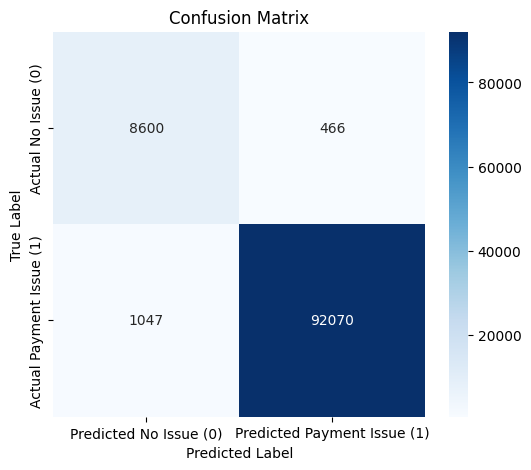

In [ ]:
# 4. Generate the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_final, y_pred_class)
cm_df = pd.DataFrame(cm, 
                     index=['Actual No Issue (0)', 'Actual Payment Issue (1)'], 
                     columns=['Predicted No Issue (0)', 'Predicted Payment Issue (1)'])

print("\n--- Confusion Matrix (Raw Counts) ---")
print(cm_df.to_markdown())

# Optional: Plot the Confusion Matrix for better visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# --- 1. Define Feature Names and Combine for Iteration ---

# Use the lists that define the structure of your inputs (as defined in the previous PFI attempt)
LSTM_INPUT_COLS = ['INSTALLMENT_NO','INSTALLMENT_AMOUNT', 'DAYS_LATE', 'DAYS_BETWEEN_DUE_DATES','PAID_RATIO', 'DELTA_DAYS_LATE','PAYMENT_SCORE', 'COMPOSITE_RISK', 'RECENT_PAYMENT_SCORE','PAYMENT_SCORE_RANK','IS_UNPAID','CURRENT_EMI_BEHAVIOR_LABEL']
# Assuming 5 OHE columns were added (adjust this number if needed)
OHE_COUNT = X_test_lstm.shape[2] - len(LSTM_INPUT_COLS) 
LSTM_INPUT_COLS.extend([f"REPAYMENT_CAT_{i}" for i in range(OHE_COUNT)])

STATIC_DENSE_COLS = ['TOTAL_INCOME', 'TOTAL_EXPENSE', 'LOAN_AMOUNT', 'AGE','CYCLE', 'CUSTOMER_FLAG_ENCODED']
# Assuming 6 OHE columns were added in the Static Dense array (adjust if needed)
OHE_STATIC_COUNT = X_test_static_dense.shape[1] - len(STATIC_DENSE_COLS)
STATIC_DENSE_COLS.extend([f"Static_OHE_{i}" for i in range(OHE_STATIC_COUNT)])

EMBEDDING_COLS = ['OCCUPATION_ENCODED', 'PURPOSE_ENCODED']

In [ ]:
# --- 2. Calculate Baseline AUC ---
print("\n--- Starting Drop Column Feature Importance Calculation ---")
from sklearn.metrics import roc_auc_score
# Predict probabilities on the clean test set
y_pred_proba_baseline = model.predict(
    [X_test_lstm, X_test_static_dense, X_test_static_embed], 
    verbose=0
)
BASELINE_AUC = roc_auc_score(y_test_final, y_pred_proba_baseline)
print(f"Baseline Test AUC: {BASELINE_AUC:.4f}")

feature_importance = {}


--- Starting Drop Column Feature Importance Calculation ---
Baseline Test AUC: 0.9964


In [ ]:
# --- 3. Iterate and Corrupt Features (LSTM Branch) ---
print("\nCorrupting LSTM features...")
for feature_index, feature_name in enumerate(LSTM_INPUT_COLS):
    
    # Create a copy of the LSTM array to avoid modifying the original data
    X_test_corrupted = X_test_lstm.copy()
    
    # Zero out the feature across all time steps (Permutation importance equivalent)
    X_test_corrupted[:, :, feature_index] = 0 
    
    # Predict and calculate AUC with the corrupted data
    y_pred_proba_corrupted = model.predict(
        [X_test_corrupted, X_test_static_dense, X_test_static_embed], 
        verbose=0
    )
    corrupted_auc = roc_auc_score(y_test_final, y_pred_proba_corrupted)
    
    # Calculate importance: Baseline AUC - Corrupted AUC
    importance = BASELINE_AUC - corrupted_auc
    feature_importance[f"LSTM_{feature_name}"] = importance


Corrupting LSTM features...


In [ ]:
# --- 4. Iterate and Corrupt Features (Static Dense Branch) ---
print("Corrupting Static Dense features...")
for feature_index, feature_name in enumerate(STATIC_DENSE_COLS):
    
    X_test_corrupted = X_test_static_dense.copy()
    
    # Zero out the feature (it's only 1 dimension, so no time steps)
    X_test_corrupted[:, feature_index] = 0 
    
    y_pred_proba_corrupted = model.predict(
        [X_test_lstm, X_test_corrupted, X_test_static_embed], 
        verbose=0
    )
    corrupted_auc = roc_auc_score(y_test_final, y_pred_proba_corrupted)
    
    importance = BASELINE_AUC - corrupted_auc
    feature_importance[f"STATIC_DENSE_{feature_name}"] = importance

Corrupting Static Dense features...


In [ ]:
# --- 5. Iterate and Corrupt Features (Embedding Branch) ---
print("Corrupting Embedding features...")
for feature_index, feature_name in enumerate(EMBEDDING_COLS):
    
    X_test_corrupted = X_test_static_embed.copy()
    
    # Zero out the encoded integer feature (0 will be treated as padding/unseen by the embedding layer)
    X_test_corrupted[:, feature_index] = 0
    
    y_pred_proba_corrupted = model.predict(
        [X_test_lstm, X_test_static_dense, X_test_corrupted], 
        verbose=0
    )
    corrupted_auc = roc_auc_score(y_test_final, y_pred_proba_corrupted)
    
    importance = BASELINE_AUC - corrupted_auc
    feature_importance[f"STATIC_EMBED_{feature_name}"] = importance

Corrupting Embedding features...


In [ ]:
# --- 6. Display Results ---
print("\n--- Top 20 Feature Importances (Measured as AUC Drop) ---")
# Convert dictionary to DataFrame for easy sorting
importance_df = pd.Series(feature_importance).sort_values(ascending=False).to_frame(name='AUC_Drop_Importance')
print(importance_df.head(20).to_markdown(floatfmt=".6f"))


--- Top 20 Feature Importances (Measured as AUC Drop) ---
|                                 |   AUC_Drop_Importance |
|:--------------------------------|----------------------:|
| LSTM_INSTALLMENT_NO             |              0.010497 |
| LSTM_PAID_RATIO                 |              0.002225 |
| LSTM_REPAYMENT_CAT_3            |              0.001795 |
| LSTM_PAYMENT_SCORE_RANK         |              0.001630 |
| LSTM_DAYS_BETWEEN_DUE_DATES     |              0.001102 |
| LSTM_COMPOSITE_RISK             |              0.000758 |
| LSTM_IS_UNPAID                  |              0.000517 |
| LSTM_CURRENT_EMI_BEHAVIOR_LABEL |              0.000480 |
| LSTM_PAYMENT_SCORE              |              0.000429 |
| LSTM_REPAYMENT_CAT_4            |              0.000347 |
| LSTM_RECENT_PAYMENT_SCORE       |              0.000223 |
| LSTM_DAYS_LATE                  |              0.000180 |
| LSTM_DELTA_DAYS_LATE            |              0.000107 |
| STATIC_EMBED_OCCUPATION_ENCODED |      

In [ ]:
# Save the final model
model.save('hybrid_lstm_model.h5')
print("✅ Hybrid Model saved to 'hybrid_lstm_model.h5'.")

✅ Hybrid Model saved to 'hybrid_lstm_model.h5'.


d:\VS_CODE_PROJECTS\CollectionEfficiencyMFI_LOS_LMS\env_local_311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


EXPORTING PREDICTIONS TO SINGLE EXCEL FILE

In [ ]:
# --- Step 9: Exporting Predictions to Single Excel File (With Inverse Transform) ---
print("\n--- Step 9: Exporting Test Predictions to Excel ---")

# Import joblib and load the preprocessor
import joblib
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np


--- Step 9: Exporting Test Predictions to Excel ---


In [ ]:
# Load the fitted preprocessor
try:
    preprocessor = joblib.load('preprocessor.pkl')
except FileNotFoundError:
    print("❌ ERROR: 'preprocessor.pkl' not found. Cannot perform inverse transformation.")
    raise

In [ ]:
# --- 1. Identify the Index for Inverse Transformation ---

# 1a. Define the name of the feature we need to unscale
INSTALLMENT_NO_COL_NAME = 'INSTALLMENT_NO'

# 1b. The `StandardScaler` (named 'num') was fitted on the list NUMERICAL_FEATURES_FINAL.
# We must find the index of 'INSTALLMENT_NO' within that list.
# NOTE: NUMERICAL_FEATURES_FINAL is defined in your current code.
try:
    # Find the index of the column within the scaler's input feature list
    scaler_feature_index = NUMERICAL_FEATURES_FINAL.index(INSTALLMENT_NO_COL_NAME)
except ValueError:
    print(f"❌ ERROR: '{INSTALLMENT_NO_COL_NAME}' not found in NUMERICAL_FEATURES_FINAL.")
    raise

In [ ]:
# 1c. Get the StandardScaler object and its stored parameters (mean and scale)
scaler = preprocessor.named_transformers_['num']
install_no_mean = scaler.mean_[scaler_feature_index]
install_no_scale = scaler.scale_[scaler_feature_index]

In [ ]:
# --- 2. Extract Scaled Values from X_test_lstm ---

# Indices are correct from your previous definition:
INSTALLMENT_NO_IDX = 0 
CURRENT_EMI_BEHAVIOR_LABEL_IDX = 11 

# Index for the last time step (the one immediately preceding the prediction)
LAST_TIME_STEP_IDX = X_test_lstm.shape[1] - 1 

# Extract the SCALED installment number values
scaled_install_no = X_test_lstm[:, LAST_TIME_STEP_IDX, INSTALLMENT_NO_IDX]

In [ ]:
# --- 3. Apply Inverse Transformation ---

# Formula: X_original = (X_scaled * scale) + mean
unscaled_install_no = (scaled_install_no * install_no_scale) + install_no_mean

# Round to the nearest whole number and convert to integer for final output
install_no_final_unscaled = np.round(unscaled_install_no).astype(np.int16)

In [ ]:
# --- 4. Prepare other results (re-using variables from Step 8) ---

# Re-run prediction steps to ensure required variables (y_pred_proba, y_pred_class) are fresh
y_pred_proba = model.predict(test_inputs, verbose=0)[:, 0] 
y_pred_class = (y_pred_proba > 0.5).astype(np.int8) 

# Extract the scaled behavior label (no inverse transform needed, as it was label encoded or left as is)
behavior_label_final = X_test_lstm[:, LAST_TIME_STEP_IDX, CURRENT_EMI_BEHAVIOR_LABEL_IDX].astype(np.int8)

In [ ]:
# --- 5. Construct Final Results DataFrame ---

results_df = pd.DataFrame({
    'Loan_ID': test_loan_ids,
    'Installment_No_of_Prediction': install_no_final_unscaled, # <--- THIS IS THE CORRECTED, UNSCALED VALUE
    'Current_EMI_Behavior_Label': behavior_label_final,
    'Actual_Next_EMI_Status': y_test_final.astype(np.int8), 
    'Model_Predicted_Status': y_pred_class,
    'Predicted_Probability': y_pred_proba.astype(np.float32)
})

In [ ]:
# --- 6. Export to a Single Excel File ---

FILE_NAME = 'Hybrid_Model_Test_Set_Predictions_1.xlsx'
SHEET_NAME = 'All_Predictions'

print(f"Exporting {results_df.shape[0]} Records to {FILE_NAME}...")

try:
    with pd.ExcelWriter(FILE_NAME, engine='xlsxwriter') as writer:
        results_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    print(f"✅ Successfully saved all predictions to: {FILE_NAME}")
except Exception as e:
    print(f"❌ ERROR saving to Excel: {e}")
    print("Please ensure you have 'xlsxwriter' installed: pip install xlsxwriter")
finally:
    del results_df

Exporting 102183 Records to Hybrid_Model_Test_Set_Predictions_1.xlsx...
✅ Successfully saved all predictions to: Hybrid_Model_Test_Set_Predictions_1.xlsx
